In [1]:
import sys
import time
print(sys.executable)
from utils import *

/Users/clivian/opt/anaconda3/bin/python


In [2]:
# ratings, lookup = loadDic()
ratings = loadDic()

In [3]:
# mostPop(ratings, 62423, sys.maxsize)

In [4]:
temp_mkeys = mostPop(ratings, 20, (2019, 1, 1))
temp_mtitles = getMovieTitleById(temp_mkeys)

['Star Wars: Episode IV - A New Hope (1977)', 'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', "Schindler's List (1993)", 'Silence of the Lambs, The (1991)', 'Godfather, The (1972)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Matrix, The (1999)', 'American Beauty (1999)', 'Fight Club (1999)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Lord of the Rings: The Two Towers, The (2002)', 'Lord of the Rings: The Return of the King, The (2003)', 'Dark Knight, The (2008)', 'WALL·E (2008)', 'Up (2009)', 'Avatar (2009)', 'Inception (2010)']


In [5]:
temp_mkeys

[2571,
 318,
 79132,
 58559,
 2959,
 356,
 4993,
 7153,
 296,
 5952,
 260,
 593,
 1196,
 858,
 527,
 60069,
 1198,
 68954,
 72998,
 2858]

In [6]:
def getRPrecision(params):
    delta_t_list = params['delta_t']
    
    month_aves = []
    year_aves = []
    
    for delta_t in delta_t_list:
        month_ave = {}
        year_ave = {}
        for year in range(2014, 2019):
            day_count = 0
            mostPop_month_precisions = []
            recentPop_month_precisions = []
            decayPop_month_precisions = []
            for month in range(1, 13):
                mostPop_day_precisions = []
                recentPop_day_precisions = []
                decayPop_day_precisions = []
                for day in range(1, 32):
                    date = (year, month, day)
                    if ratings.get(date, -1) == -1:
                        print('date', date, 'invalid')
                        continue
                    day_count += 1
                    user_activities = getUserActivities(ratings[date])
                    max_R = getMaxR(user_activities)
                    day_recentPop = day_decayPop = delta_t
                    
                    max_R_mostPop, max_R_recentPop, max_R_decayPop = (
                        mostPop(ratings, max_R, date),
                        recentPop(ratings, max_R, date, day_recentPop),
                        decayPop(ratings, max_R, date, day_decayPop)
                    )

                    mostPop_cur, recentPop_cur, decayPop_cur = (
                        RPrecision(user_activities, max_R_mostPop),
                        RPrecision(user_activities, max_R_recentPop),
                        RPrecision(user_activities, max_R_decayPop)
                    )
                    
                    mostPop_day_precisions.append(mostPop_cur)
                    recentPop_day_precisions.append(recentPop_cur)
                    decayPop_day_precisions.append(decayPop_cur)
                    
                mostPop_month_ave = sum(mostPop_day_precisions)/len(mostPop_day_precisions)
                recentPop_month_ave = sum(recentPop_day_precisions)/len(recentPop_day_precisions)
                decayPop_month_ave = sum(decayPop_day_precisions)/len(decayPop_day_precisions)

                mostPop_month_precisions.append(mostPop_month_ave)
                recentPop_month_precisions.append(recentPop_month_ave)
                decayPop_month_precisions.append(decayPop_month_ave)
                
                month_ave[(year, month)] = (mostPop_month_ave, 
                                            recentPop_month_ave, 
                                            decayPop_month_ave)
            
            mostPop_year_ave = sum(mostPop_month_precisions)/len(mostPop_month_precisions)
            recentPop_year_ave = sum(recentPop_month_precisions)/len(recentPop_month_precisions)
            decayPop_year_ave = sum(decayPop_month_precisions)/len(decayPop_month_precisions)

            year_ave[year] = (mostPop_year_ave, 
                              recentPop_year_ave, 
                              decayPop_year_ave)
            print(day_count)
        month_aves.append(month_ave)
        year_aves.append(year_ave)
    return month_aves, year_aves

In [7]:
start = time.time() 
params = {}
# params['delta_t'] = [1, 2]
params['delta_t'] = [1, 2, 4, 8, 16, 32]
month_aves, year_aves = getRPrecision(params)
end = time.time()
elapse = end - start
print(elapse)

date (2014, 2, 29) invalid
date (2014, 2, 30) invalid
date (2014, 2, 31) invalid
date (2014, 3, 19) invalid
date (2014, 4, 31) invalid
date (2014, 6, 31) invalid
date (2014, 9, 31) invalid
date (2014, 11, 31) invalid
364
date (2015, 2, 29) invalid
date (2015, 2, 30) invalid
date (2015, 2, 31) invalid
date (2015, 4, 31) invalid
date (2015, 6, 31) invalid
date (2015, 9, 31) invalid
date (2015, 11, 31) invalid
365
date (2016, 2, 30) invalid
date (2016, 2, 31) invalid
date (2016, 3, 17) invalid
date (2016, 4, 31) invalid
date (2016, 6, 31) invalid
date (2016, 9, 31) invalid
date (2016, 11, 31) invalid
365
date (2017, 2, 29) invalid
date (2017, 2, 30) invalid
date (2017, 2, 31) invalid
date (2017, 4, 31) invalid
date (2017, 6, 31) invalid
date (2017, 9, 31) invalid
date (2017, 11, 31) invalid
365
date (2018, 1, 7) invalid
date (2018, 1, 8) invalid
date (2018, 2, 29) invalid
date (2018, 2, 30) invalid
date (2018, 2, 31) invalid
date (2018, 4, 31) invalid
date (2018, 6, 31) invalid
date (2018

<ipython-input-89-47170e82be6d>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(year_x)


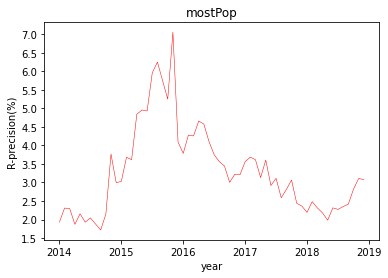

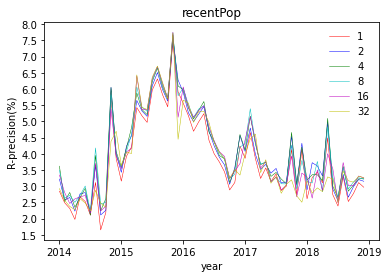

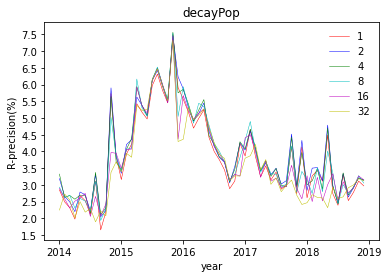

In [89]:
# for month_ave in month_aves:
#     print(month_ave)
# print(year_aves)
year_month_x = []
year_x = []
for year in range(2013, 2020):
    year_x.append(str(year))
    for month in range(1, 13):
        year_month_x.append(str(year) + '/' + str(month))
temp_x = [i for i in range(0, 60)]
methods = ['mostPop', 'recentPop', 'decayPop']
colors = ['r', 'b', 'g', 'c', 'm', 'y']

# plot monthly average
mostPop_y_each_param = []
recentPop_y_each_param = []
decayPop_y_each_param = []
for month_ave in month_aves:
    mostPop_y = []
    recentPop_y = []
    decayPop_y = []
    for year in range(2014, 2019):
        for month in range(1, 13):
            mostPop_y.append(month_ave[(year, month)][0] * 100)
            recentPop_y.append(month_ave[(year, month)][1] * 100)
            decayPop_y.append(month_ave[(year, month)][2] * 100)
    mostPop_y_each_param.append(mostPop_y)
    recentPop_y_each_param.append(recentPop_y)
    decayPop_y_each_param.append(decayPop_y)
y_each_param = [mostPop_y_each_param, recentPop_y_each_param, decayPop_y_each_param]
for i in range(0, len(methods)):
    fig, ax = plt.subplots()
    import matplotlib.ticker as plticker
    x_loc = plticker.MultipleLocator(base=12)
    y_loc = plticker.MultipleLocator(base=0.5)
    ax.xaxis.set_major_locator(x_loc)
    ax.yaxis.set_major_locator(y_loc)
    ax.set_title(str(methods[i]), loc='center')
    if methods[i] == 'mostPop':
        param = params['delta_t'][0]
        ax.plot(temp_x, y_each_param[i][0], color=colors[0], linewidth=0.5)
    else:
        for j in range(0, len(params['delta_t'])):
            param = params['delta_t'][j]
            ax.plot(temp_x, y_each_param[i][j], color=colors[j], linewidth=0.5, label=str(param))
        ax.legend(loc='upper right', frameon=False)
    ax.set_xticklabels(year_x)
    ax.set_xlabel('year')
    ax.set_ylabel('R-precision(%)' )
    fig.savefig('./figures/monthly_average_' + str(methods[i]), bbox_inches='tight', dpi=300)

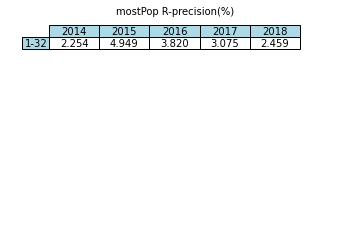

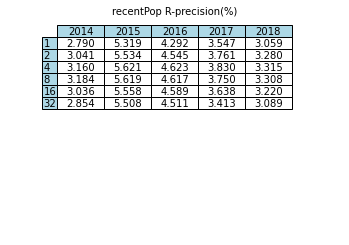

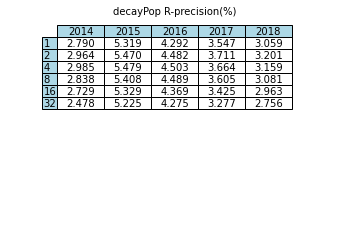

In [88]:
# plot yearly average
mostPop_y_each_param = []
recentPop_y_each_param = []
decayPop_y_each_param = []
for year_ave in year_aves:
    mostPop_y = []
    recentPop_y = []
    decayPop_y = []
    for year in range(2014, 2019):
        mostPop_y.append("%.3f" % (year_ave[year][0] * 100))
        recentPop_y.append("%.3f" % (year_ave[year][1] * 100))
        decayPop_y.append("%.3f" % (year_ave[year][2] * 100))
    mostPop_y_each_param.append(mostPop_y)
    recentPop_y_each_param.append(recentPop_y)
    decayPop_y_each_param.append(decayPop_y)
y_each_param = [mostPop_y_each_param, recentPop_y_each_param, decayPop_y_each_param]
for i in range(0, len(methods)):
    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    ax.set_title(str(methods[i]) + ' R-precision(%)', loc='center', fontsize=10)
    if methods[i] == 'mostPop':
        table = ax.table(
            cellText = [y_each_param[i][0]],
            colLabels = [year for year in range(2014, 2019)],
            rowLabels = ['1-32'],
            rowColours =["lightblue"] * 1,  
            colColours =["lightblue"] * len(y_each_param[i]), 
            colWidths=[0.15] * len(y_each_param[i]),
            cellLoc ='center',
            loc ='upper center',
        )
    else:
        table = ax.table(
            cellText = y_each_param[i],
            rowLabels = params['delta_t'],
            colLabels = [year for year in range(2014, 2019)],
            rowColours =["lightblue"] * len(y_each_param[i]),  
            colColours =["lightblue"] * len(y_each_param[i]), 
            colWidths=[0.14] * len(y_each_param[i]),
            cellLoc ='center',
            loc ='upper center',
        )
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    bbox = bbox.from_extents(bbox.xmin-5, bbox.ymin-5, bbox.xmax+5, bbox.ymax+25)
    bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('./figures/yearly_average_' + str(methods[i]), bbox_inches=bbox_inches, dpi=300)
    

In [10]:
# num_of_day = [i for i in range(1, 15)] 
# pop_method = ['mostPop', 'recentPop', 'decayPop'] 
# precision_data = np.array([mostPop_precision_collection, 
#                   recentPop_precision_collection, 
#                   decayPop_precision_collection]).transpose()
# fig, ax = plt.subplots() 
# ax.set_axis_off() 
# table = ax.table( 
#     cellText = precision_data,  
#     rowLabels = num_of_day,
#     colLabels = pop_method,
#     rowColours =["palegreen"] * len(precision_data),  
#     colColours =["palegreen"] * len(precision_data), 
#     colWidths=[0.5] * len(precision_data),
#     cellLoc ='center',  
#     loc ='upper left')         
# ax.set_title('R-precision', 
#              fontweight ='bold') 
# plt.savefig('./figures/rprecision_day_year10toyear15', bbox_inches='tight')